## EDA y Transformación de la información para el modelo

In [549]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast

In [550]:
dfeda = pd.read_csv("Archivos/dfSteamFunciones.csv")

In [551]:
dfeda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32134 entries, 0 to 32133
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Editor             24063 non-null  object 
 1   Género             31103 non-null  object 
 2   Título             32132 non-null  object 
 3   Url                32134 non-null  object 
 4   Fecha_lanzamiento  30067 non-null  object 
 5   Temas              31971 non-null  object 
 6   Precio_descuento   225 non-null    float64
 7   Url_reseñas        32132 non-null  object 
 8   Especificaciones   31464 non-null  object 
 9   Precio             30750 non-null  float64
 10  Acceso_temprano    32134 non-null  bool   
 11  Id                 32132 non-null  float64
 12  Desarrollador      28835 non-null  object 
 13  Sentimiento        32134 non-null  object 
 14  Metascore          2607 non-null   float64
 15  Año                29966 non-null  float64
dtypes: bool(1), float64(5)

In [552]:
dfeda.replace('nan',np.nan,inplace=True)
dfeda.replace('Sin Dato',np.nan,inplace=True)

In [553]:
dfeda.count().sort_values()

Precio_descuento       225
Metascore             2607
Sentimiento          15260
Editor               24063
Desarrollador        28835
Año                  29966
Fecha_lanzamiento    30067
Precio               30750
Género               31103
Especificaciones     31464
Temas                31971
Título               32132
Url_reseñas          32132
Id                   32132
Url                  32134
Acceso_temprano      32134
dtype: int64

A continuación eliminamos varias columnas.
Precio_descuento y Metascore por tener muy pocos registros.
Url reseñas, Id, Título, Url, Temas, Desarrollador y Editor las eliminamos por no contar info que sea valiosa para el modelo.

In [554]:
dfeda.drop(columns=['Precio_descuento','Metascore','Url_reseñas','Título','Url','Temas','Desarrollador','Editor','Id'],inplace=True)

Teniendo en cuenta que lo que buscamos predecir es el precio, no nos suman información aquellos registros que o no tienen información sobre el precio(1384 registros) o que son gratis o tienen precio 0 (1900 registros).  
Estos registros los eliminaremos del modelo

In [555]:
print(len(dfeda['Precio'][dfeda['Precio']==0]),len(dfeda['Precio'][pd.isna(dfeda['Precio'])]))

1900 1384


In [556]:
dfeda.dropna(subset=['Precio'],inplace=True)

### Análisis de Outliers
Tomando como criterio de Outliers la regla de los 3 sigmas, eliminaríamos alrededor de 300 registros de los casi 30.000.
Sin embargo, como podemos ver del análisis por categoría a continuación estaríamos afectando a las categorías que tienen mayores precios y haciendo que el modelo pierda precisión.

In [557]:
type(dfeda['Género'])

pandas.core.series.Series

In [558]:
dfeda['Género'].fillna('[]',inplace=True)
dfeda['Género'] = dfeda['Género'].apply(ast.literal_eval)
dfeda['Género'] = dfeda['Género'].apply(lambda x: np.nan if not x else x)
Géneros = dfeda['Género'].explode().unique()

dfeda['Especificaciones'].fillna('[]',inplace=True)
dfeda['Especificaciones'] = dfeda['Especificaciones'].apply(ast.literal_eval)
dfeda['Especificaciones'] = dfeda['Especificaciones'].apply(lambda x: np.nan if not x else x)
Géneros = dfeda['Especificaciones'].explode().unique()




(0.0, 20000.0)

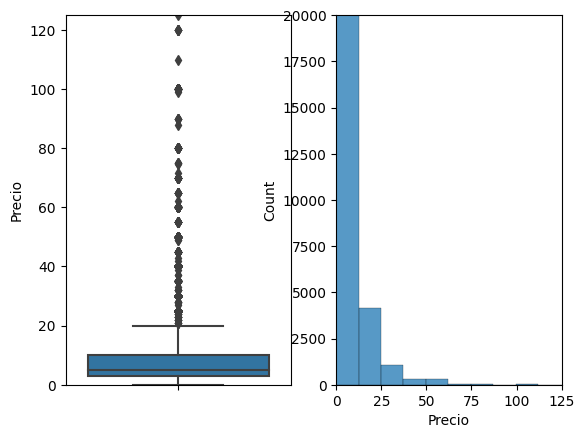

In [559]:
ig,axes = plt.subplots(1,2)
sns.boxplot(y='Precio',data=dfeda,ax = axes[0])
sns.histplot(data=dfeda,x='Precio',bins=80,ax=axes[1])
axes[0].set_ylim(0,125)
axes[1].set_xlim(0,125)
axes[1].set_ylim(0,20000)

In [560]:
dfeda[['Género','Precio']][(dfeda['Precio']>200)].sort_values('Precio',ascending=False)


,Género,Precio
12088,"[Animation &amp; Modeling, Design &amp; Illust...",995.00
2392,[Simulation],771.71
23593,"[Simulation, Action, RPG, Free to Play]",599.00
17793,"[Free to Play, Massively Multiplayer, RPG]",499.99
14303,"[Animation &amp; Modeling, Design &amp; Illust...",499.99
24999,NaN,499.00
25000,"[Indie, Simulation]",449.00
9074,"[Animation &amp; Modeling, Design &amp; Illust...",399.99
9075,"[Animation &amp; Modeling, Design &amp; Illust...",399.99
9417,[Video Production],399.00


In [561]:
dfprueba = dfeda[['Género','Precio']]
df_exploded = dfprueba.explode('Género')

# Hacer un merge entre 'df' y 'df_exploded' utilizando el índice para mantener la información de las otras columnas
result_df = dfprueba.merge(df_exploded, left_index=True, right_index=True)

In [562]:
result_df.head(3)

,Género_x,Precio_x,Género_y,Precio_y
0,"[Action, Casual, Indie, Simulation, Strategy]",4.99,Action,4.99
0,"[Action, Casual, Indie, Simulation, Strategy]",4.99,Casual,4.99
0,"[Action, Casual, Indie, Simulation, Strategy]",4.99,Indie,4.99


(0.0, 125.0)

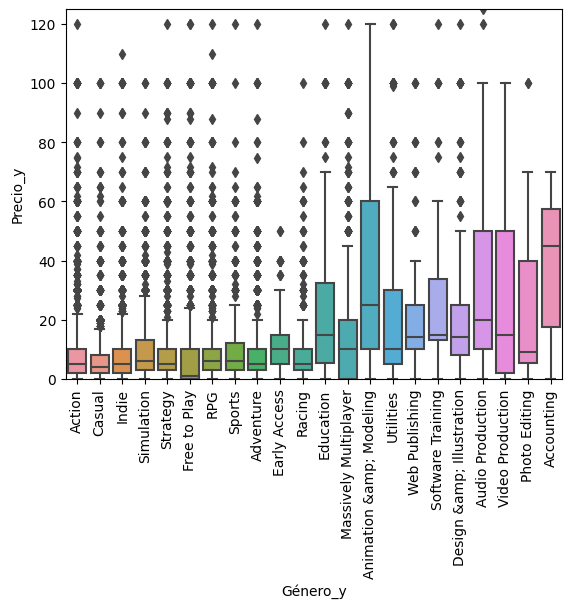

In [563]:
sns.boxplot(y='Precio_y',data=result_df,x='Género_y')
plt.xticks(rotation=90)
plt.ylim(0,125)

In [564]:
dfeda.dropna(subset=['Género'],inplace=True)

In [565]:
print('Desviación estandar de',dfeda['Precio'].std(),' y media de',dfeda['Precio'].mean())

Desviación estandar de 16.228777998626665  y media de 9.010453536847766


In [566]:
a=5*dfeda['Precio'].std()+dfeda['Precio'].mean()
a

90.15434352998109

In [567]:
len(dfeda[dfeda['Precio']>92])

120

In [568]:
dfeda.drop(dfeda[(dfeda['Precio']>92)].index,inplace = True)

Como podemos apreciar, pareciera ser que las categorías podrían ser un buen predictor de los precios ya que tienen distribuciones, medidas de tendencia central y cuartiles muy distintos.  
Inicialmente habías considerado eliminar outliers por regla de 3 sigmas, pero realizando este análisis vemos que sería un análisis muy sesgado para algunos géneros. Por esto optamos por eliminar outliers con precios a más de 5 desviaciones estandar (92 pesos), eliminando solo unos 110 registros. Si analizamos esta decisión gráficamente, vemos que estamos tomando como criterio en los géneros con mayores precios el criterio de rango intercueartil.  
  
Además, teniendo en cuenta que trabajaremos con Gnero como predictor, eliminaremos aquellos registros vacíos

### Análisis en el tiempo
A continuación, analizaremos la evolución en el tiempo de los registros relacionados al precio.  
Primero que nada analizaremos tanto los precios medios como las cantidad de registros anuales.

(1989.0, 2020.0)

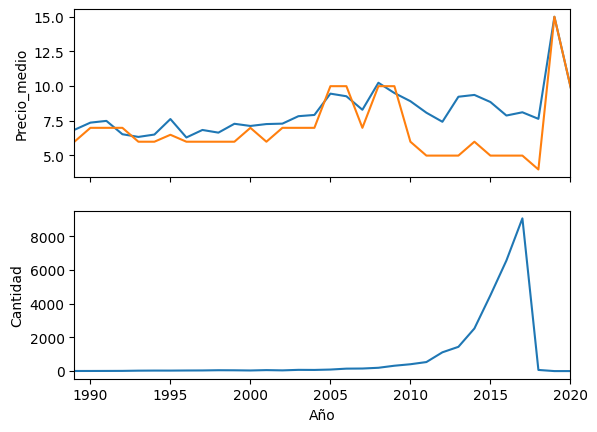

In [569]:
fig,axes = plt.subplots(2,1,sharex=True)
pr_medio = dfeda.groupby('Año')['Precio'].agg(Precio_medio = 'mean',Mediana = 'median',Cantidad='count')
sns.lineplot(data=pr_medio, x='Año', y='Precio_medio',ax=axes[0])
sns.lineplot(data=pr_medio, x='Año', y='Mediana',ax=axes[0])
sns.lineplot(data=pr_medio, x='Año', y='Cantidad',ax=axes[1])
plt.xlim(1989,2020)

Se puede ver como la mayor cantidad de registros se encuentran entre el año 2006 y 2018, y además podemos ver como las medidas de tendencia central son bastante similiares.  
Por este motivo, y sumado a que analizar precios anteriores no sería del todo correcto por las variaciones del mercado, es que optamos por tomar para el modelo el período entre 2007 y 2018.

In [570]:
dfeda.drop(dfeda[(dfeda['Año']<2007)|(dfeda['Año']>2018)].index,inplace = True)

In [571]:
dfeda['Mes'] = pd.to_datetime(dfeda['Fecha_lanzamiento'],errors='coerce').dt.month
#dfeda['Fecha_lanzamiento'][1]

<Axes: xlabel='Mes', ylabel='Cantidad'>

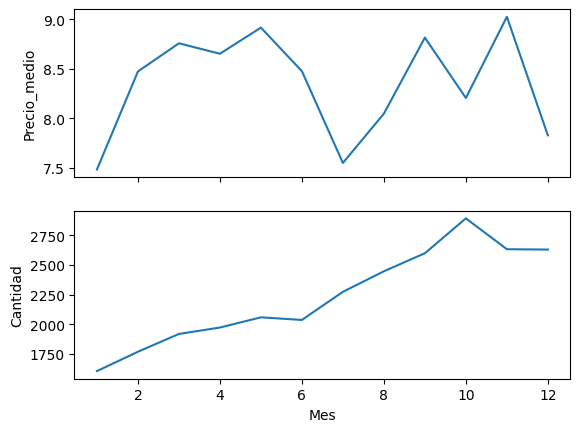

In [572]:
fig,axes = plt.subplots(2,1,sharex=True)
pr_medio = dfeda.groupby('Mes')['Precio'].agg(Precio_medio = 'mean',Mediana = 'median',Cantidad='count')

sns.lineplot(data=pr_medio, x='Mes', y='Precio_medio',ax=axes[0])

sns.lineplot(data=pr_medio, x='Mes', y='Cantidad',ax=axes[1])


Como vemos no hay una gran variedad de precios, pero si parece haber una estacionalidad en los meses del año. Por eso por el momento eliminarémos año y fecha de lanzamiento pero mantendremos mes de lanzamiento

In [573]:
dfeda.drop(columns=['Fecha_lanzamiento','Año'],inplace=True)

### Análisis Sentimiento

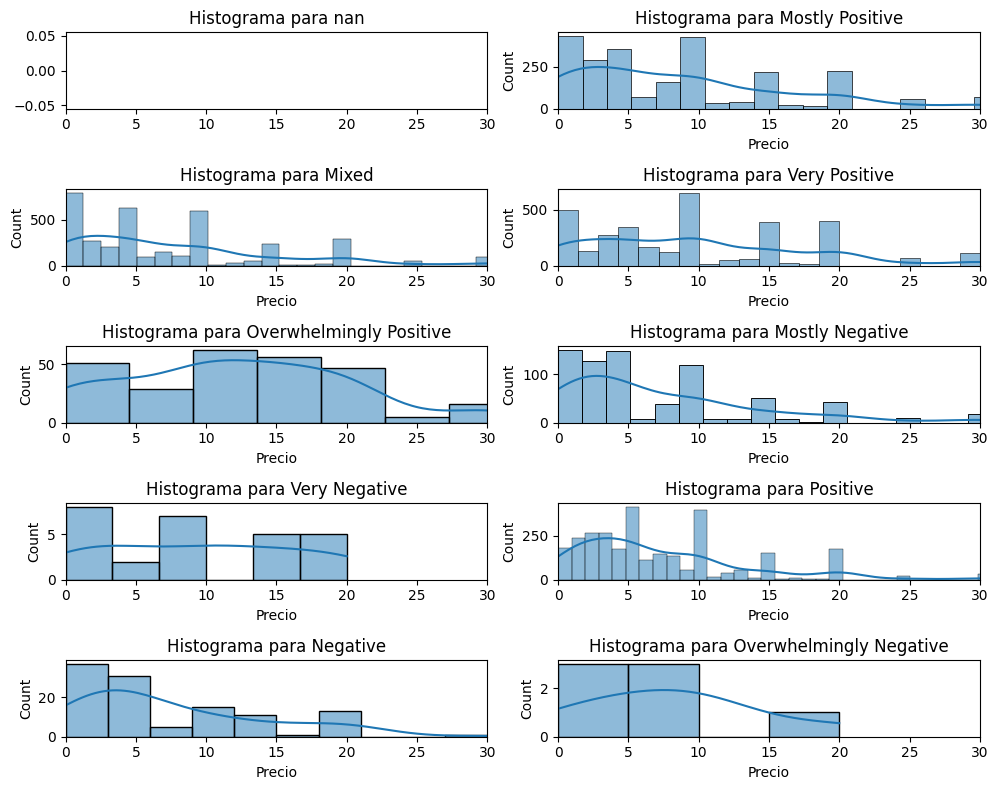

In [574]:
#sns.histplot(data=dfeda,x='Precio',hue='Sentimiento')
categorias_unicas = dfeda['Sentimiento'].unique()

# Calcular el número de filas y columnas necesarias para los subplots
num_filas = len(categorias_unicas) // 2 + len(categorias_unicas) % 2
num_columnas = 2

# Crear un objeto de figura y ejes utilizando plt.subplots()
fig, axes = plt.subplots(nrows=num_filas, ncols=num_columnas, figsize=(10, 8))

# Graficar histogramas en los subplots para cada categoría
for i, categoria in enumerate(categorias_unicas):
    fila = i // num_columnas
    columna = i % num_columnas
    sns.histplot(data=dfeda[dfeda['Sentimiento'] == categoria], x='Precio', kde=True, ax=axes[fila, columna])
    axes[fila, columna].set_title(f'Histograma para {categoria}')

# Ajustar los subplots para evitar superposiciones
plt.tight_layout()
for fila in axes:
    for eje in fila:
        eje.set_xlim(0,30)
# Mostrar los subplots
plt.show()

In [575]:
dfeda.groupby('Sentimiento')['Precio'].agg(Precio_medio = 'mean',Mediana = 'median',Cantidad='count')

,Precio_medio,Mediana,Cantidad
Sentimiento,,,
Mixed,9.358459,5.99,3821
Mostly Negative,8.133682,4.99,755
Mostly Positive,10.542177,7.99,2513
Negative,8.033565,4.99,115
Overwhelmingly Negative,8.277143,9.99,7
Overwhelmingly Positive,13.137007,11.99,274
Positive,8.051352,4.99,2965
Very Negative,9.731852,9.99,27
Very Positive,11.331411,9.99,3473


Luego de este análisis, llego a la conclusión que no sería una buena práctica cargar en el modelo 'Sentimiento' ya que además de tener muy pocos registros su media es muy distinta a la de toda la muestra.

In [576]:
dfeda['Precio'][pd.notna(dfeda['Sentimiento'])].describe()

count    13950.000000
mean         9.782254
std         10.262640
min          0.000000
25%          2.990000
50%          6.990000
75%         14.990000
max         89.990000
Name: Precio, dtype: float64

In [577]:
dfeda['Precio'].describe()

count    28786.000000
mean         8.387854
std          9.483331
min          0.000000
25%          2.990000
50%          4.990000
75%          9.990000
max         89.990000
Name: Precio, dtype: float64

In [578]:
dfeda.drop(columns='Sentimiento',inplace=True)

### Especificaciones

(0.0, 50.0)

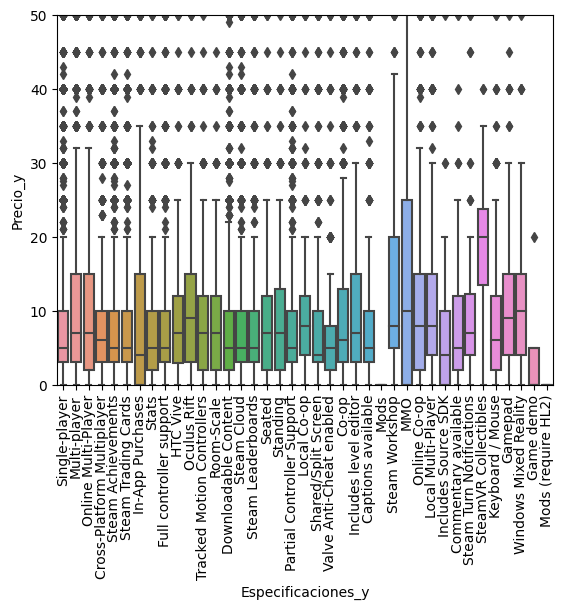

In [579]:
dfprueba = dfeda[['Especificaciones','Precio']]
df_exploded = dfprueba.explode('Especificaciones')

# Hacer un merge entre 'df' y 'df_exploded' utilizando el índice para mantener la información de las otras columnas
result_df = dfprueba.merge(df_exploded, left_index=True, right_index=True)
sns.boxplot(y='Precio_y',data=result_df,x='Especificaciones_y')
plt.xticks(rotation=90)
plt.ylim(0,50)

Como vemos, las especificaciones no suman mucha información al modelo por lo que optamos por eliminarla.

In [580]:
dfeda.drop(columns='Especificaciones',inplace  =True)

### Acceso Temprano
Como podemos ver, podría ser un buen predictor del modelo por lo cual lo vamos a mantener.

(0.0, 50.0)

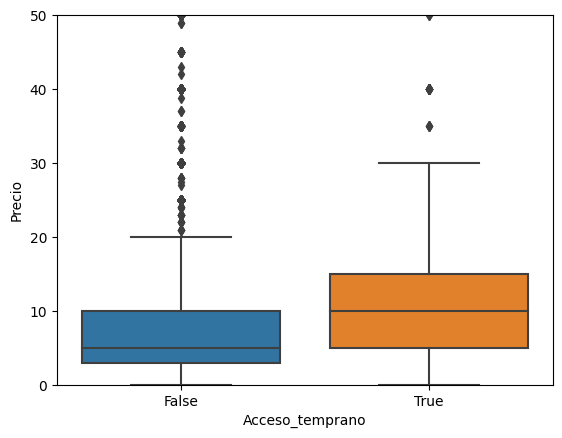

In [581]:
sns.boxplot(data=dfeda,x='Acceso_temprano',y='Precio')
plt.ylim(0,50)

### Transformación de datos para el modelo de ML
Nos vamos a quedar en principio con estas variables(Género,Acceso_Temprano y mes) para predecir el precio
A continuación vamos eliminar los nulos quedandonos con casi 27.000 registro para el entrenamiento del modelo y vamos a transformar las variables a numéricas para poder realizar un heatmap que nos permita analizar si tenemos todavía variables redundantes que podamos eliminar

In [582]:
dfeda.dropna(inplace=True)

Transformamos los datos de genres con get dummies, agregandole el prefijo Genres, por el momento no eliminamos la col original

In [583]:
dummies_genres = pd.get_dummies(dfeda['Género'].explode(),prefix = 'Género').groupby(level=0).sum()
dfml = pd.concat([dfeda,dummies_genres],axis=1)


Ahora modificamos a numérica la variable numérica Acceso_temprano y procedemos a eliminar las columnas correspondientes

In [584]:
dfml['Acceso_temprano_num'] =dfml['Acceso_temprano'].astype(int)

In [585]:
dfml.drop(columns=['Género','Acceso_temprano'],inplace=True)

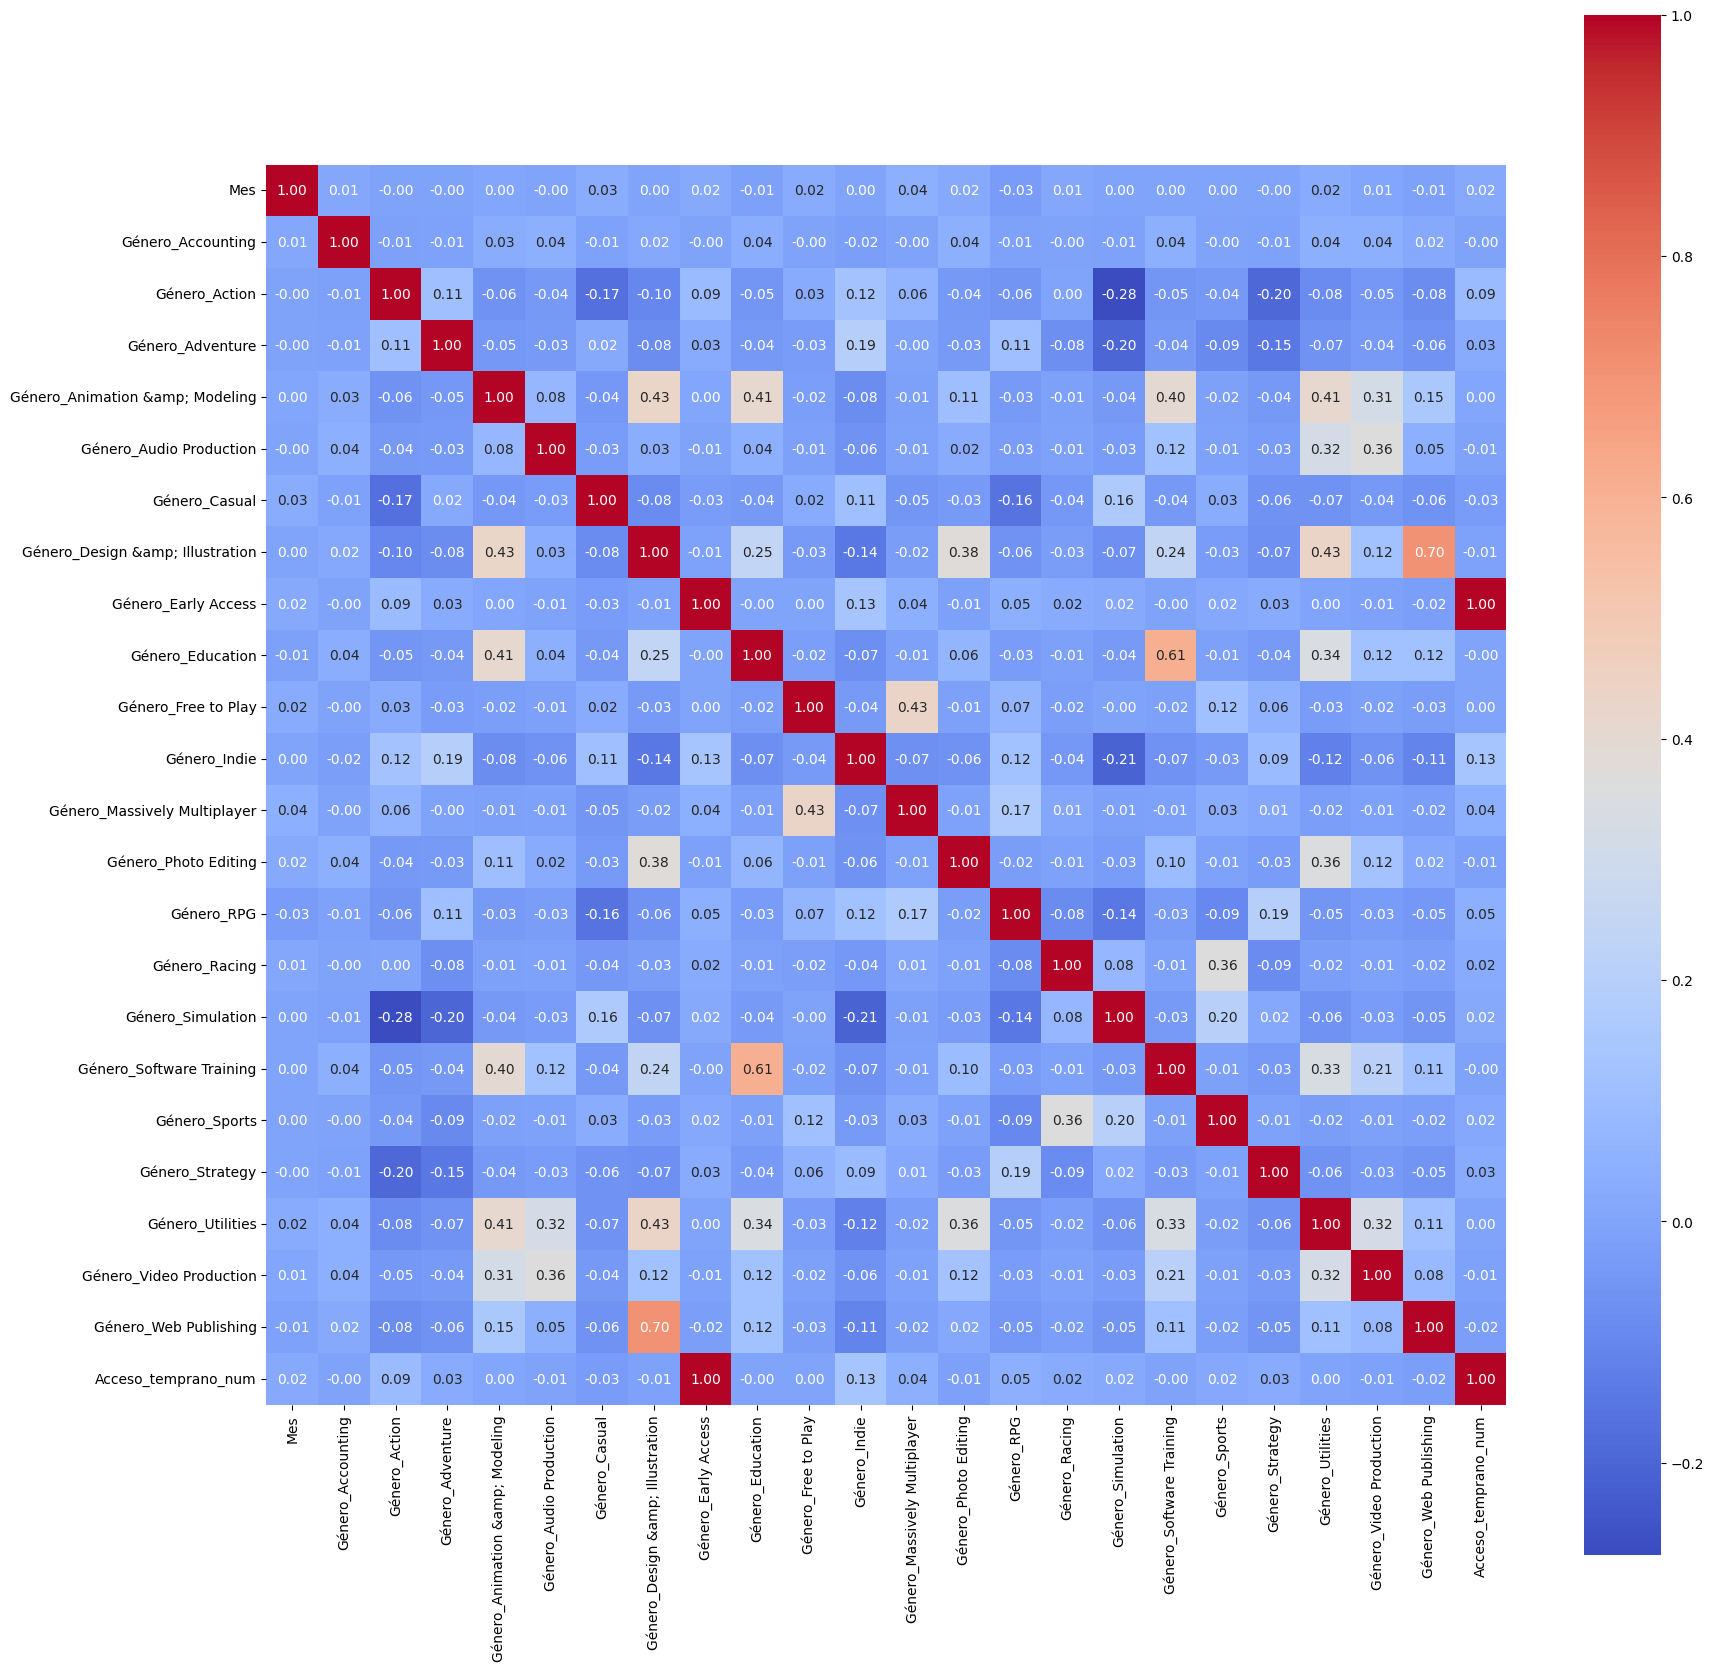

In [586]:
matriz_correlacion = dfml.drop(columns='Precio').corr()

# Crear el heatmap utilizando Seaborn
plt.figure(figsize=(20,20))
sns.heatmap(matriz_correlacion, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10},cmap= 'coolwarm')
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)

plt.show()

Si bien es redundantes, no eliminamos Acceso temprano por pedido del cliente.


In [587]:
"""
dummies_mes = pd.get_dummies(dfml['Mes'].explode()).groupby(level=0).sum()
dfml = pd.concat([dfml,dummies_mes],axis=1)
dfml.drop(columns=['Mes'],inplace=True)
"""

"\ndummies_mes = pd.get_dummies(dfml['Mes'].explode()).groupby(level=0).sum()\ndfml = pd.concat([dfml,dummies_mes],axis=1)\ndfml.drop(columns=['Mes'],inplace=True)\n"

In [588]:
dfml.to_csv('Archivos/dfML.csv',index=False)